In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 2 of the nanoCOP manuscript. 
                                            

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
import re
% matplotlib inline

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool


In [2]:
# function to label missing gene names with transcript names
def name_missing_genes(row):
    if pd.isnull(row['gene']):
        return (row['transcript'])

    else:
        return (row['gene'])


# output downsampled bed files for ONT correlation plots
def get_downsampled_bamtobed(bamFile_A, bamFile_B):
        
    bedFile_A = bamFile_A.bam_to_bed(split=True) 
    bedFile_B = bamFile_B.bam_to_bed(split=True) 

    N = min(len(bedFile_A), len(bedFile_B))

    downsampled_bedFile_A = bedFile_A.sample(n=N)
    downsampled_bedFile_B = bedFile_B.sample(n=N)
    
    return downsampled_bedFile_A, downsampled_bedFile_B


# output downsampled bed files for ONT correlation plots
def get_replicate_coverage_df(bamFile_A, bamFile_B, genes_bed):
        
    read_bed_A, read_bed_B = get_downsampled_bamtobed(bamFile_A, bamFile_B)

    # get number of reads that overlap each gene feature
    coverage_A = genes_bed.coverage(read_bed_A, s=True, mean=True) 
    coverage_A_df = coverage_A.to_dataframe() 
    coverage_A_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns
    coverage_A_df = coverage_A_df[coverage_A_df['coverage']>0]

    coverage_B = genes_bed.coverage(read_bed_B, s=True, mean=True) 
    coverage_B_df = coverage_B.to_dataframe() 
    coverage_B_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns
    coverage_B_df = coverage_B_df[coverage_B_df['coverage']>0]
    
    return coverage_A_df, coverage_B_df


# output downsampled bed files for ONT correlation plots
def get_coverage_df(bamFile, genes_bed):
        
    bedFile = bamFile.bam_to_bed(split=True) 

    # get number of reads that overlap each gene feature
    coverage = genes_bed.coverage(bedFile, s=True, mean=True) 
    coverage_df = coverage.to_dataframe() 
    coverage_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns
    coverage_df['coverage'] = coverage_df['coverage'].replace(0, 0.0005)
    
    return coverage_df


# output downsampled bed files for ONT correlation plots
def get_counts_df(bamFile, genes_bed):
        
    bedFile = bamFile.bam_to_bed(split=False) 

    # get number of reads that overlap each gene feature
    counts = genes_bed.coverage(bedFile, s=True, counts=True) 
    counts_df = counts.to_dataframe() 
    counts_df.columns =['chrom','start','end','transcript','score','strand','gene','counts'] # label columns
    counts_df['counts'] = counts_df['counts'].replace(0, 0.2)
    
    return counts_df


# determine gene counts per gene for ONT reads
def get_ONT_gene_counts(gene_bed, read_bed):
        
    # get number of reads that overlap each gene feature
    coverage = gene_bed.coverage(read_bed, s=True, counts=True) 
    
    # make a dataframe from coverage file
    df = coverage.to_dataframe() # covert to dataframe
    df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
    df = df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords
    
    # get read counts per gene
    freq = df['count'].value_counts() 

    return freq


# determine gene counts per gene for ONT reads
def get_ONT_gene_IDs(gene_bed, read_bed):
        
    # get number of reads that overlap each gene feature
    coverage = gene_bed.coverage(read_bed, s=True, counts=True) 
    
    # make a dataframe from coverage file
    df = coverage.to_dataframe() # covert to dataframe
    df.columns =['chrom','start','end','gene','score','strand','count'] # label columns
    df = df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords
    
    # get read counts per gene
    freq = df['count'].value_counts() 

    return freq


# output downsampled bed files for ONT correlation plots
def get_downsampled_bed(alignment_stats_df, downsample_N):
        
    downsampled_bedFile = alignment_stats_df.sample(n=downsample_N)
    
    return downsampled_bedFile


# get alignment stats information from bamFile
def get_alignment_stats(iBAM):

    alignment_stats = []

    # read in Bam file line by line
    for read in iBAM:

        # set variables to cigar string before summing
        M = 0    # number of alignment matches
        I = 0    # number of alignment insertions
        D = 0    # number of alignment deletions
        N = 0    # number of skipped nucleotdies from splicing
        S = 0    # number of softclipped nucleotides
        H = 0    # number of hardclipped nucleotides
        P = 0
        E = 0
        X = 0
        B = 0

        # only record data if read is aligned 
        if(read.rname!=-1):

            name = read.qname     # get read name  
            cigar = read.cigar    # get cigar string for read 

            # get NM which details edit distance to reference genome
            for i in range(0,len(read.tags)):
                if(read.tags[i][0]=='NM'):
                    NM=read.tags[i][1]

            # sum up the number of matches for each representative 
            # letter in the cigar string
            for i in range(0,len(cigar)):
                if(cigar[i][0]==0):
                    M = M + cigar[i][1]
                if(cigar[i][0]==1):
                    I = I + cigar[i][1]
                if(cigar[i][0]==2):
                    D = D + cigar[i][1]
                if(cigar[i][0]==3):
                    N = N + cigar[i][1]
                if(cigar[i][0]==4):
                    S = S + cigar[i][1]
                if(cigar[i][0]==5):
                    H = H + cigar[i][1]
                if(cigar[i][0]==6):
                    P = P + cigar[i][1]
                if(cigar[i][0]==7):
                    E = E + cigar[i][1]
                if(cigar[i][0]==8):
                    X = X + cigar[i][1]
                if(cigar[i][0]==9):
                    B = B + cigar[i][1]

            readLength = M + I + S
            alignLength = M + D
            align_percent = float(M) / float(readLength) * 100.0
            match_count = M + I - NM       
            match_percent = float(match_count) / float(M + I) * 100.0
            alignment_stats.append([read.qname,readLength,alignLength,align_percent,match_count,match_percent])
    alignment_stats_df = pd.DataFrame(alignment_stats)
    alignment_stats_df.columns = ['read','read_length','aligned_length','align_percent','match_count','match_percent']

    iBAM.close()
    
    return alignment_stats_df


def get_score_df(seq_bed_df, sample_num):
    score = pd.DataFrame([[0 for y in range(4)] for x in range(4)])
    score.columns = ['A','T','C','G']
    score.index = ['A','T','C','G']

    seq_bed_df = seq_bed_df.sample(n=sample_num)
    
    for i in range(0,len(seq_bed_df)):

        cigar = seq_bed_df.iloc[i]['cigar_seq']
        reference = seq_bed_df.iloc[i]['ref_seq']

        if (len(cigar) != len(reference)):
            print("ERROR: line "+str(i))

        if (len(cigar) == len(reference)):
            for j in range(0,len(cigar)):
                if ((cigar[j]!='N') & (reference[j]!='N')):
                    score[cigar[j]][reference[j]] = score[cigar[j]][reference[j]] + 1
                
    return score


def get_read_length_df(fastq):
    count=0
    readLength_list = []

    for line in fastq:

        count+=1

        if (count%4==1):
            name = line.split('@')[1].split(' ')[0]

        if (count%4==2):
            seq = line
            read_length = len(line)

        if (count%4==0):
            readLength_list.append([name, read_length])

    readLength_df = pd.DataFrame(readLength_list)
    readLength_df.columns = ['name','length']

    return readLength_df


# determine gene counts per gene for ONT reads
def get_read_number_at_genes(gene_bed, read_bed):
        
    # get number of reads that overlap each gene feature
    coverage = gene_bed.coverage(read_bed, s=True, counts=True) 
    
    # make a dataframe from coverage file
    df = coverage.to_dataframe() # covert to dataframe
    df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
    df = df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords

    return df


# function to label missing gene names with transcript names
def get_gene_count_percent(read_counts):
    
    percent_list = []

    for i in range(0,len(read_counts)):
        
        total_percent = np.sum(read_counts[:i+1]['percent'])
        
        percent_list.append(total_percent)
    
    percent_df = pd.DataFrame(percent_list)
    read_counts['percent_sum'] = percent_df
    
    return read_counts


In [3]:
# SUPPLEMENTAL FIGURE 2A - nano-COP K562 correlation plots

# upload gene information as a BedTool for parsing
hg38_genes_df = pd.read_csv('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None, sep='\t')
hg38_genes_df = hg38_genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
hg38_genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
hg38_genes_df['gene_length'] = hg38_genes_df['end']-hg38_genes_df['start']
hg38_genes_df['transcript'] = hg38_genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
hg38_genes_df = hg38_genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
hg38_names_df = pd.read_csv('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None, sep='\t')
hg38_names_df.columns = ['gene','transcript']

hg38_genes_names_merge = pd.merge(hg38_genes_df, hg38_names_df, on=['transcript'], how='left')
hg38_genes_names_merge['gene'] = hg38_genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
hg38_genes_names_merge = hg38_genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
hg38_genes_names_merge = hg38_genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

hg38_genes_names_merge = hg38_genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
hg38_genes_bed = BedTool.from_dataframe(hg38_genes_names_merge)

# get K562 ONT coverage information for all replicates
K562_rep1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_1_hg38_minimap2_uniq_sort.bam')
K562_rep2_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_2_hg38_minimap2_uniq_sort.bam')
K562_rep3_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_3_hg38_minimap2_uniq_sort.bam')
K562_rep4_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_4_hg38_minimap2_uniq_sort.bam')
K562_rep5_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5_hg38_minimap2_uniq_sort.bam') # This is the merged BAM file from replicates 5a and 5b



In [4]:
# get number of reads that overlap each gene feature
K562_rep1_counts_df = get_counts_df(K562_rep1_bamFile, hg38_genes_bed)
K562_rep2_counts_df = get_counts_df(K562_rep2_bamFile, hg38_genes_bed)
K562_rep3_counts_df = get_counts_df(K562_rep3_bamFile, hg38_genes_bed)
K562_rep4_counts_df = get_counts_df(K562_rep4_bamFile, hg38_genes_bed)
K562_rep5_counts_df = get_counts_df(K562_rep5_bamFile, hg38_genes_bed)

#K562_rep1_N = int(len(K562_rep1_bamFile))
#K562_rep2_N = int(len(K562_rep2_bamFile))
#K562_rep3_N = int(len(K562_rep3_bamFile))

K562_rep1_N = int(np.sum(K562_rep1_counts_df[K562_rep1_counts_df['counts']!=0.2]['counts']))
K562_rep2_N = int(np.sum(K562_rep2_counts_df[K562_rep2_counts_df['counts']!=0.2]['counts']))
K562_rep3_N = int(np.sum(K562_rep3_counts_df[K562_rep3_counts_df['counts']!=0.2]['counts']))
K562_rep4_N = int(np.sum(K562_rep4_counts_df[K562_rep4_counts_df['counts']!=0.2]['counts']))
K562_rep5_N = int(np.sum(K562_rep5_counts_df[K562_rep5_counts_df['counts']!=0.2]['counts']))


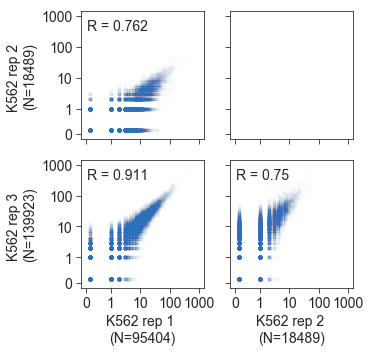

In [187]:
# prepare a plot with correlations between ONT replicate datasets

# make a correlation plot for all replicate samples
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(5.25,5))

# plot for rep 1 vs. rep 3
merge = pd.merge(K562_rep1_counts_df,K562_rep2_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax1 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax1)
ax1.set_xlabel('',fontsize=14)
ax1.set_ylabel("K562 rep 2 \n(N="+str(K562_rep2_N)+")",fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax1.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


# plot for rep 1 vs. rep 3
merge = pd.merge(K562_rep1_counts_df,K562_rep3_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax3 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax3)
ax3.set_xlabel("K562 rep 1 \n(N="+str(K562_rep1_N)+")",fontsize=14)
ax3.set_ylabel("K562 rep 3 \n(N="+str(K562_rep3_N)+")",fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax3.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


# plot for rep 2 vs. rep 3
merge = pd.merge(K562_rep2_counts_df,K562_rep3_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax4 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax4)
ax4.set_xlabel("K562 rep 2 \n(N="+str(K562_rep2_N)+")",fontsize=14)
ax4.set_ylabel('',fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax4.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


plt.xlim(-1,3.15)
plt.ylim(-1,3.15)


#x_labels = ["1","10","$\mathregular{10^{-3}}$","$\mathregular{10^{-1}}$","$\mathregular{10^{1}}$"]
x_labels = ["0","1","10","100","1000"]
plt.xticks([np.log10(0.15),0,1,2,3], x_labels, fontsize=14)

y_labels = ["0","1","10","100","1000"]
plt.yticks([np.log10(0.15),0,1,2,3], y_labels, fontsize=14)

ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax3.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax4.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_2A_K562_ONT_vs_ONT_correlation_plot.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [4]:
# SUPPLEMENTAL FIGURE 2B - nano-COP S2 correlation plots

# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
dm6_genes_df = pd.read_csv('/path/to/annotation_files/dm6_RefSeq_genes_parsed.bed',header=None, sep='\t')
#genes_df = genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
dm6_genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
dm6_genes_df['gene_length'] = dm6_genes_df['end']-dm6_genes_df['start']
dm6_genes_df['transcript'] = dm6_genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
dm6_genes_df = dm6_genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
dm6_names_df = pd.read_csv('/path/to/annotation_files/dm6_RefSeq_names_parsed.txt', header=None, sep='\t')
dm6_names_df.columns = ['gene','transcript']

dm6_genes_names_merge = pd.merge(dm6_genes_df, dm6_names_df, on=['transcript'], how='left')
dm6_genes_names_merge['gene'] = dm6_genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
dm6_genes_names_merge = dm6_genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
dm6_genes_names_merge = dm6_genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

dm6_genes_names_merge = dm6_genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)
dm6_genes_names_merge['chrom'] = 'chr'+dm6_genes_names_merge['chrom']

# create a bed file for all unique genes
dm6_genes_bed = BedTool.from_dataframe(dm6_genes_names_merge)


# get S2 ONT coverage information for all replicates
S2_rep1_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_1_dm6_minimap2_uniq_sort.bam')  # This is the merged BAM file from replicates 1a and 1b
S2_rep2_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_2_dm6_minimap2_uniq_sort.bam')
S2_rep3_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_3_dm6_minimap2_uniq_sort.bam')

In [5]:
# get number of reads that overlap each gene feature
S2_rep1_counts_df = get_counts_df(S2_rep1_bamFile, dm6_genes_bed)
S2_rep2_counts_df = get_counts_df(S2_rep2_bamFile, dm6_genes_bed)
S2_rep3_counts_df = get_counts_df(S2_rep3_bamFile, dm6_genes_bed)

#S2_rep1_N = int(len(S2_rep1_bamFile))
#S2_rep2_N = int(len(S2_rep2_bamFile))
#S2_rep3_N = int(len(S2_rep3_bamFile))

S2_rep1_N = int(np.sum(S2_rep1_counts_df[S2_rep1_counts_df['counts']!=0.2]['counts']))
S2_rep2_N = int(np.sum(S2_rep2_counts_df[S2_rep2_counts_df['counts']!=0.2]['counts']))
S2_rep3_N = int(np.sum(S2_rep3_counts_df[S2_rep3_counts_df['counts']!=0.2]['counts']))


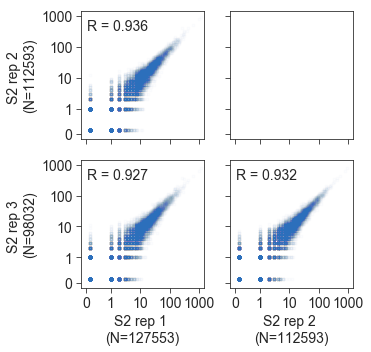

In [189]:
# prepare a plot with correlations between ONT replicate datasets

# make a correlation plot for all replicate samples
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(5.25,5))

# plot for rep 1 vs. rep 3
merge = pd.merge(S2_rep1_counts_df,S2_rep2_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax1 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax1)
ax1.set_xlabel('',fontsize=14)
ax1.set_ylabel("S2 rep 2 \n(N="+str(S2_rep2_N)+")",fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax1.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


# plot for rep 1 vs. rep 3
merge = pd.merge(S2_rep1_counts_df,S2_rep3_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax3 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax3)
ax3.set_xlabel("S2 rep 1 \n(N="+str(S2_rep1_N)+")",fontsize=14)
ax3.set_ylabel("S2 rep 3 \n(N="+str(S2_rep3_N)+")",fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax3.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


# plot for rep 2 vs. rep 3
merge = pd.merge(S2_rep2_counts_df,S2_rep3_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax4 = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False, ax=ax4)
ax4.set_xlabel("S2 rep 2 \n(N="+str(S2_rep2_N)+")",fontsize=14)
ax4.set_ylabel('',fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
ax4.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)


plt.xlim(-1,3.15)
plt.ylim(-1,3.15)


#x_labels = ["1","10","$\mathregular{10^{-3}}$","$\mathregular{10^{-1}}$","$\mathregular{10^{1}}$"]
x_labels = ["0","1","10","100","1000"]
plt.xticks([np.log10(0.15),0,1,2,3], x_labels, fontsize=14)

y_labels = ["0","1","10","100","1000"]
plt.yticks([np.log10(0.15),0,1,2,3], y_labels, fontsize=14)

ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax3.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax4.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_2B_S2_ONT_vs_ONT_correlation_plot.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [24]:
# SUPPLEMENTAL FIGURE 2I - Illumina vs. ONT correlation plots

# get K562 ONT coverage information for both replicates
ONT_bamFile = pybedtools.BedTool('/path/to/all_K562_hg38_minimap2_uniq_sort.bam') # This is a merged BAM file from all K562 replicates

ONT_bedFile = ONT_bamFile.bam_to_bed(split=True) 

ONT_coverage = hg38_genes_bed.coverage(ONT_bedFile, s=True, mean=True) 
ONT_coverage_df = ONT_coverage.to_dataframe() 
ONT_coverage_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns

# get coverage information for both Illumina sequencing dataset
Ill_R1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_1_R1_Aligned.sortedByCoord.out.uniq.bam')

Ill_R1_bedFile = Ill_R1_bamFile.bam_to_bed(split=True) 

Ill_R1_coverage = genes_bed.coverage(Ill_R1_bedFile, s=True, mean=True) 
Ill_R1_coverage_df = Ill_R1_coverage.to_dataframe() 
Ill_R1_coverage_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns

ONT_coverage_df2 = ONT_coverage_df[ONT_coverage_df['coverage']>0]
Ill_R1_coverage_df2 = Ill_R1_coverage_df[Ill_R1_coverage_df['coverage']>0]



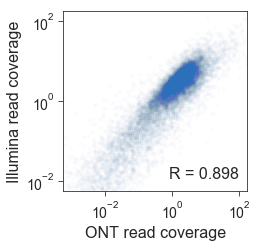

In [25]:
# prepare a plot with correlations between ONT replicate datasets

# make a correlation plot for all replicate samples
fig, ax = plt.subplots(figsize=(3.3,3.3))

# plot for ONT vs. ONT RNA sample
merge = pd.merge(ONT_coverage_df2,Ill_R1_coverage_df2,on=['gene'],how="inner")
A=np.log10(merge['coverage_x'])
B=np.log10(merge['coverage_y'])

ax = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", scatter_kws={'alpha':0.01}, fit_reg=False)
ax.set_xlabel('ONT read coverage',fontsize=16)
ax.set_ylabel('Illumina read coverage',fontsize=16)
pcor = np.corrcoef(A, B)[0, 1]
ax.text(2,-2,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='bottom',fontsize=16)

plt.xlim(-3.25,2.25)
plt.ylim(-2.25,2.25)

x_labels = ["$\mathregular{10^{-2}}$","$\mathregular{10^{0}}$","$\mathregular{10^{2}}$"]
plt.xticks([-2,0,2], x_labels, fontsize=14)

y_labels = ["$\mathregular{10^{-2}}$","$\mathregular{10^{0}}$","$\mathregular{10^{2}}$"]
plt.yticks([-2,0,2], y_labels, fontsize=14)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)


plt.savefig('/path/to/Supplemental_Figure_2I_ONT_vs_Ill_correlation_plot_2.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()


In [5]:
# SUPPLEMENTAL FIGURE 2G - nano-COP read counts per gene

# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None)
genes_df = genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)
#genes_names_merge['chrom'] = 'chr'+genes_names_merge['chrom']

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)



In [6]:
# get K562 ONT coverage information for all replicates
K562_bamFile = pybedtools.BedTool('/path/to/all_K562_hg38_minimap2_uniq_sort.bam')
K562_bedFile = K562_bamFile.bam_to_bed()

K562_gene_freq = get_ONT_gene_counts(gene_bed, K562_bedFile)

K562_gene_freq = K562_gene_freq[K562_gene_freq.index<100]


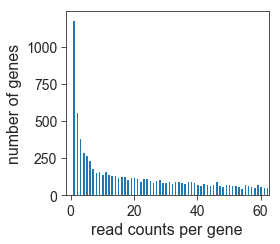

In [17]:
fig, ax = plt.subplots(figsize=(4,3.5))

ax.bar(K562_gene_freq.index[1:],K562_gene_freq.values[1:])
ax.set_xlim(-1.5,62.5)
ax.set_xlabel("read counts per gene", fontsize=16)
ax.set_ylabel("number of genes", fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.tight_layout()

plt.savefig('/path/to/Supplemental_Figure_2G_K562_ONT_read_counts_per_gene_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()


In [7]:
# get number of reads that overlap each gene feature
K562_coverage = gene_bed.coverage(K562_bedFile, s=True, counts=True) 

# make a dataframe from coverage file
K562_df = K562_coverage.to_dataframe() # covert to dataframe
K562_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
K562_df = K562_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords



In [8]:
print("Number of genes with coverage in K562 data: "+str(len(K562_df[K562_df['count']>0])))

Number of genes with coverage in K562 data: 13358


In [9]:
np.sum(K562_df['count'])


1114380

In [10]:
K562_df['count'].describe()

count    19281.000000
mean        57.796795
std        148.777245
min          0.000000
25%          0.000000
50%         11.000000
75%         67.000000
max      12426.000000
Name: count, dtype: float64

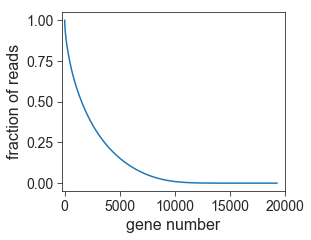

In [11]:
# SUPPLEMENTAL FIGURE 2H - nano-COP proportion of genes represented

K562_read_counts = get_read_number_at_genes(gene_bed, K562_bedFile)
K562_read_counts['percent'] = K562_read_counts['count'].astype(float)/float(np.sum(K562_read_counts['count']))
K562_read_counts = K562_read_counts.sort_values(by='percent').reset_index(drop=True)
K562_read_counts = get_gene_count_percent(K562_read_counts)

fig, ax = plt.subplots(figsize=(4,3.3))

K562_read_counts_reversed = K562_read_counts.iloc[::-1].reset_index(drop=True)

ax = sns.lineplot(K562_read_counts_reversed.index, K562_read_counts_reversed['percent_sum'])

plt.xticks(fontsize=16)
plt.yticks([0.0,0.25,0.5,0.75,1.0], fontsize=16)

plt.xlim(-250,20000)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of reads", fontsize=16)
ax.set_xlabel("gene number", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_2H_allK562polyA_ONT_fraction_of_reads_per_gene_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [49]:
# calculating top 10% by total counts per gene
percent10=int(np.round(len(K562_read_counts)*0.1))
top10_reads = np.sum(K562_read_counts[-percent10:]['count'])
all_reads = np.sum(K562_read_counts['count'])

print("# of nano-COP reads in top 10% genes: "+str(top10_reads))
print("# of nano-COP reads in all genes: "+str(all_reads))

print("% nano-COP reads in top 10% expressed genes: "+str(np.round(top10_reads/all_reads*100,2))+"%")


# of nano-COP reads in top 10% genes: 627707
# of nano-COP reads in all genes: 1114380
% nano-COP reads in top 10% expressed genes: 56.33%


In [50]:
# calculating top 10% by total counts per gene length per gene
K562_read_counts['coverage']=K562_read_counts['count']/(K562_read_counts['end']-K562_read_counts['start'])
cutoff=K562_read_counts['coverage'].quantile(q=0.9)
top10_reads = np.sum(K562_read_counts[K562_read_counts['coverage']>cutoff]['count'])
all_reads = np.sum(K562_read_counts['count'])

print("# of nano-COP reads in top 10% genes: "+str(top10_reads))
print("# of nano-COP reads in all genes: "+str(all_reads))

print("% nano-COP reads in top 10% expressed genes: "+str(np.round(top10_reads/all_reads*100,2))+"%")


# of nano-COP reads in top 10% genes: 329687
# of nano-COP reads in all genes: 1114380
% nano-COP reads in top 10% expressed genes: 29.58%


In [6]:
# SUPPLEMENTAL FIGURE 2C - nano-COP read match percent

# download files for Supplemental Figure 2C-F

# read in BAM file
nascent_iBAM=pysam.Samfile("/path/to/all_K562_hg38_minimap2_uniq_sort.bam", 'rb')
UCSC_iBAM=pysam.Samfile("/path/to/RNA_consortium_data/UCSC_Run1_hg38_minimap2_uniq_sort.bam", 'rb')
Hopkins_iBAM=pysam.Samfile("/path/to/RNA_consortium_data/Hopkins_Run1_hg38_minimap2_uniq_sort.bam", 'rb')

# get alignment stats from bam file
nascent_alignment_stats_df = get_alignment_stats(nascent_iBAM)
UCSC_alignment_stats_df = get_alignment_stats(UCSC_iBAM)
Hopkins_alignment_stats_df = get_alignment_stats(Hopkins_iBAM)

# downsample all datasets for comparisons
downsample_N = min(len(nascent_alignment_stats_df),len(UCSC_alignment_stats_df),len(Hopkins_alignment_stats_df))

nascent_downsample = get_downsampled_bed(nascent_alignment_stats_df, downsample_N)
UCSC_downsample = get_downsampled_bed(UCSC_alignment_stats_df, downsample_N)
Hopkins_downsample = get_downsampled_bed(Hopkins_alignment_stats_df, downsample_N)


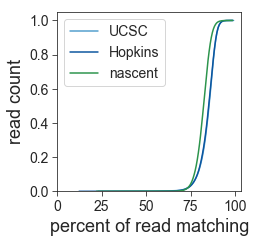

In [7]:
# match percent = (MD tag / Cigar M)
# this is the 1 - (base mismatches / total bases that align to the genome)

fig, ax = plt.subplots(figsize=(3.3,3.3))

nascent_match = nascent_downsample[nascent_downsample['match_percent']>0]['match_percent'].values
UCSC_match = UCSC_downsample[UCSC_downsample['match_percent']>0]['match_percent'].values
Hopkins_match = Hopkins_downsample[Hopkins_downsample['match_percent']>0]['match_percent'].values

ax = sns.distplot(UCSC_match, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=100, label='UCSC')
sns.distplot(Hopkins_match, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=100, label='Hopkins')
sns.distplot(nascent_match, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=100, label='nascent')

x_labels = ["0","25","50","75","100"]
plt.xticks([0,25,50,75,100], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("percent of read matching", fontsize=18)
ax.legend(fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_2C_alldRNA_matchPercent_cumdist_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
nascent_Hopkins_dif = np.round(np.median(Hopkins_match)-np.median(nascent_match),3)
nascent_UCSC_dif = np.round(np.median(UCSC_match)-np.median(nascent_match),3)

print("match percent differential: "+str(nascent_Hopkins_dif)+"-"+str(nascent_UCSC_dif))


match percent differential: 2.917-3.102


In [9]:
# T test statistics

names = ['nascent','UCSC','Hopkins']

stats_list = []

for i in range(0,len(names)-1):
    for j in range(i+1,len(names)):

        name1="%s_downsample" % names[i]
        name2="%s_downsample" % names[j]
        
        t, p = ttest_ind(eval(name1)['match_percent'],eval(name2)['match_percent'])
        stats_list.append([names[i], names[j], t, p])

        
Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['name_1', 'name_2', 'KS valuet', 'p-value']

Ttest_stats_df       


,name_1,name_2,KS valuet,p-value
0,nascent,UCSC,-149.912569,0.000000e+00
1,nascent,Hopkins,-145.671629,0.000000e+00
2,UCSC,Hopkins,5.462831,4.690707e-08


In [5]:
# SUPPLEMENTAL FIGURE 2D - nano-COP confusion matrices

# read in sequence matrix files - these were made with the script nanoCOP_confusion_matrices_datasets.ipynb

Nascent_Run3_seq_df = pd.read_table('/path/to/nanoCOP_K562_3_confusion_matrix_seq_df.txt', 
                                    dtype={"chrom": str, "start": int, "end": int, "cigar_seq": str, "cigar": str, "strand": str, "ref_seq": str})

UCSC_Run1_seq_df = pd.read_table('/path/to/UCSC_Run1_confusion_matrix_seq_df.txt', 
                                    dtype={"chrom": str, "start": int, "end": int, "cigar_seq": str, "cigar": str, "strand": str, "ref_seq": str})

Hopkins_Run1_seq_df = pd.read_table('/path/to/Hopkins_Run1_confusion_matrix_seq_df.txt', 
                                    dtype={"chrom": str, "start": int, "end": int, "cigar_seq": str, "cigar": str, "strand": str, "ref_seq": str})


In [6]:
# get sequence bed file
Nascent_Run3_score_df = get_score_df(Nascent_Run3_seq_df, 100000)
Nascent_Run3_score_percent_df = Nascent_Run3_score_df.apply(lambda row: row.astype(float) / row.sum(axis=0), axis=1)


In [7]:
# get sequence bed file
UCSC_Run1_score_df = get_score_df(UCSC_Run1_seq_df, 100000)
UCSC_Run1_score_percent_df = UCSC_Run1_score_df.apply(lambda row: row.astype(float) / row.sum(axis=0), axis=1)


In [8]:
# get sequence bed file
Hopkins_Run1_score_df = get_score_df(Hopkins_Run1_seq_df, 100000)
Hopkins_Run1_score_percent_df = Hopkins_Run1_score_df.apply(lambda row: row.astype(float) / row.sum(axis=0), axis=1)


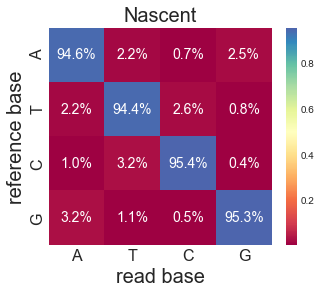

In [12]:
fig, ax = plt.subplots(figsize=(5,4))

sns.heatmap(Nascent_Run3_score_percent_df, annot=True, center=0.50, annot_kws={"size": 14}, fmt='.1%', cmap='Spectral')

plt.xlabel("read base", fontsize=20)
plt.ylabel("reference base", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

plt.title('Nascent', fontsize=20)

plt.savefig('/path/to/Supplemental_Figure_2D_Nascent_Run3_confusion_matrix_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


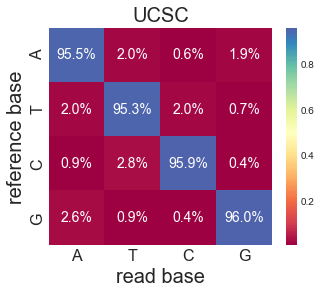

In [13]:
fig, ax = plt.subplots(figsize=(5,4))

sns.heatmap(UCSC_Run1_score_percent_df, annot=True, center=0.50, annot_kws={"size": 14}, fmt='.1%', cmap='Spectral')

plt.xlabel("read base", fontsize=20)
plt.ylabel("reference base", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

plt.title('UCSC', fontsize=20)

plt.savefig('/path/to/Supplemental_Figure_2D_UCSC_Run1_confusion_matrix_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


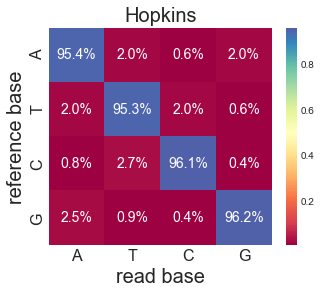

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

sns.heatmap(Hopkins_Run1_score_percent_df, annot=True, center=0.50, annot_kws={"size": 14}, fmt='.1%', cmap='Spectral')

plt.xlabel("read base", fontsize=20)
plt.ylabel("reference base", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

plt.title('Hopkins', fontsize=20)

plt.savefig('/path/to/Supplemental_Figure_2D_Hopkins_Run1_confusion_matrix_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [39]:
# SUPPLEMENTAL FIGURE 2E - nano-COP read length distributions

# get fastq files
nascent_fastq = open('/path/to/K562_4sUchr_ONT_3_basecall.fastq')
UCSC_fastq = open('/path/to/RNA_consortium_data/UCSC_Run1_20170907_DirectRNA.pass.dedup.fastq')
Hopkins_fastq = open('/path/to/RNA_consortium_data/Hopkins_Run1_20170928_DirectRNA.pass.dedup.fastq')

# get read length dataframes for all samples
nascent_read_length_df = get_read_length_df(nascent_fastq)
UCSC_read_length_df = get_read_length_df(UCSC_fastq)
Hopkins_read_length_df = get_read_length_df(Hopkins_fastq)


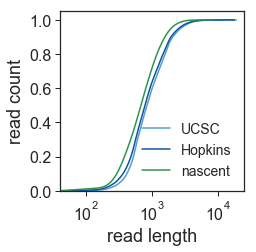

In [40]:
fig, ax = plt.subplots(figsize=(3.3,3.3))

nascent_length = np.log10(nascent_read_length_df['length'].values)
UCSC_length = np.log10(UCSC_read_length_df['length'].values)
Hopkins_length = np.log10(Hopkins_read_length_df['length'].values)

ax = sns.distplot(UCSC_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=100, label='UCSC')
sns.distplot(Hopkins_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=100, label='Hopkins')
sns.distplot(nascent_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[4], bins=100, label='nascent')

x_labels = ["$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$"]
plt.xticks([2,3,4], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', direction='out', length=5, width=1)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("read length", fontsize=18)
ax.legend(loc=0, fontsize=14)

plt.xlim(1.6,4.4)

plt.savefig('/path/to/Supplemental_Figure_2E_ONT_dRNA_readlength_comparisons_cdf_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [45]:
nascent_Hopkins_dif = np.round(np.median(Hopkins_read_length_df['length'])-np.median(nascent_read_length_df['length']),3)
nascent_UCSC_dif = np.round(np.median(UCSC_read_length_df['length'])-np.median(nascent_read_length_df['length']),3)

print("length differential: "+str(nascent_Hopkins_dif)+"-"+str(nascent_UCSC_dif))


length differential: 95.0-164.0


In [46]:
# T test statistics

names = ['nascent','UCSC','Hopkins']

stats_list = []

for i in range(0,len(names)-1):
    for j in range(i+1,len(names)):

        name1="%s_downsample" % names[i]
        name2="%s_downsample" % names[j]
        
        t, p = ttest_ind(eval(name1)['match_percent'],eval(name2)['match_percent'])
        stats_list.append([names[i], names[j], t, p])

        
Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['name_1', 'name_2', 'KS valuet', 'p-value']

Ttest_stats_df       


,name_1,name_2,KS valuet,p-value
0,nascent,UCSC,-150.691265,0.000000e+00
1,nascent,Hopkins,-146.002858,0.000000e+00
2,UCSC,Hopkins,5.881820,4.063244e-09


In [ ]:
# Supplemenatl Fig 2F

In [13]:
# get fastq files
K562_1_fastq = open('/path/to/K562_4sUchr_ONT_1_basecall.fastq')
K562_2_fastq = open('/path/to/K562_4sUchr_ONT_2_basecall.fastq')
K562_3_fastq = open('/path/to/K562_4sUchr_ONT_3_basecall.fastq')

S2_1a_fastq = open('/path/to/S2_4sUchr_ONT_1a_basecall.fastq')
S2_1b_fastq = open('/path/to/S2_4sUchr_ONT_1b_basecall.fastq')
S2_2_fastq = open('/path/to/S2_4sUchr_ONT_2_basecall.fastq')
S2_3_fastq = open('/path/to/S2_4sUchr_ONT_3_basecall.fastq')

# get read length dataframes for all samples
K562_1_read_length_df = get_read_length_df(K562_1_fastq)
K562_2_read_length_df = get_read_length_df(K562_2_fastq)
K562_3_read_length_df = get_read_length_df(K562_3_fastq)

S2_1a_read_length_df = get_read_length_df(S2_1a_fastq)
S2_1b_read_length_df = get_read_length_df(S2_1b_fastq)
S2_2_read_length_df = get_read_length_df(S2_2_fastq)
S2_3_read_length_df = get_read_length_df(S2_3_fastq)


In [14]:
K562_1_read_length_df['length'].describe()

count    165537.000000
mean        813.130551
std         580.400204
min          12.000000
25%         405.000000
50%         666.000000
75%        1063.000000
max        7162.000000
Name: length, dtype: float64

In [15]:
K562_2_read_length_df['length'].describe()

count    29640.000000
mean       807.007018
std        578.103322
min         11.000000
25%        410.000000
50%        648.000000
75%       1033.000000
max       7420.000000
Name: length, dtype: float64

In [16]:
K562_3_read_length_df['length'].describe()

count    214571.000000
mean        827.233168
std         568.192090
min          16.000000
25%         427.000000
50%         679.000000
75%        1063.000000
max        6972.000000
Name: length, dtype: float64

In [17]:
S2_1a_read_length_df['length'].describe()

count    131754.000000
mean        640.522717
std         446.149372
min          15.000000
25%         341.000000
50%         508.000000
75%         806.000000
max        8242.000000
Name: length, dtype: float64

In [18]:
S2_1b_read_length_df['length'].describe()

count    122068.000000
mean        623.825786
std         423.804737
min          22.000000
25%         338.000000
50%         500.000000
75%         787.000000
max        6481.000000
Name: length, dtype: float64

In [19]:
S2_2_read_length_df['length'].describe()

count    238929.000000
mean        544.682483
std         377.373710
min          18.000000
25%         312.000000
50%         418.000000
75%         670.000000
max       11264.000000
Name: length, dtype: float64

In [20]:
S2_3_read_length_df['length'].describe()

count    212880.000000
mean        574.810508
std         406.694401
min          22.000000
25%         322.000000
50%         439.000000
75%         709.000000
max       11664.000000
Name: length, dtype: float64

In [24]:
# get fastq files from new K562 replicates
K562_4_fastq = open('/path/to/K562_4sUchr_ONT_4_basecall.fastq')
K562_5a_fastq = open('/path/to/K562_4sUchr_ONT_5a_basecall.fastq')
K562_5b_fastq = open('/path/to/K562_4sUchr_ONT_5b_basecall.fastq')


# get read length dataframes for all samples
K562_4_read_length_df = get_read_length_df(K562_4_fastq)
K562_5a_read_length_df = get_read_length_df(K562_5a_fastq)
K562_5b_read_length_df = get_read_length_df(K562_5b_fastq)

K562_5_read_length_df = pd.concat([K562_5a_read_length_df,K562_5b_read_length_df]).reset_index(drop=True)


In [29]:
K562_4_read_length_df['length'].describe()

count    792087.000000
mean        747.839183
std         716.898825
min           2.000000
25%         291.000000
50%         542.000000
75%         972.000000
max       89564.000000
Name: length, dtype: float64

In [31]:
K562_5a_read_length_df['length'].describe()

count    398721.000000
mean        620.768630
std         591.241591
min           2.000000
25%         256.000000
50%         468.000000
75%         815.000000
max       48603.000000
Name: length, dtype: float64

In [32]:
K562_5b_read_length_df['length'].describe()

count    409848.000000
mean        645.742953
std         511.433627
min           2.000000
25%         299.000000
50%         502.000000
75%         829.000000
max        8383.000000
Name: length, dtype: float64